# 02. Neural Network classification with PyTorch

Classification is a problem whether something is one thing or another (there can be multiple things as the options.)

In [183]:
## 1. Make Classification data and get it ready

In [184]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

#create circles

X,Y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [185]:
len(X) , len(Y)

(1000, 1000)

In [186]:
X[:5]

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       [-0.39373073,  0.69288277],
       [ 0.44220765, -0.89672343]])

In [187]:
Y[:5]

array([1, 1, 1, 1, 0], dtype=int64)

In [188]:
# Make Dataframe of circle data
import pandas as pd

circle = pd.DataFrame({"X1":X[:,0],
                       "X2":X[:,1],
                       "Labels":Y})

In [189]:
circle.head()

,X1,X2,Labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


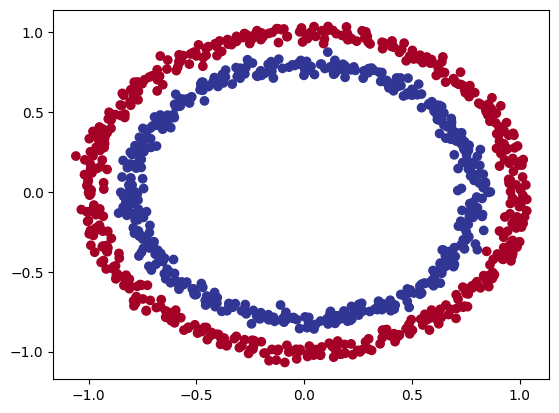

In [190]:
# Visualize 

import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=Y,
            cmap=plt.cm.RdYlBu);

**Note:** The data we are working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals

# 1.1 Check input and output shapes

In [191]:
X.shape,Y.shape

((1000, 2), (1000,))

In [192]:
# View the first example of feature and labels
X_sample = X[0]
Y_sample = Y[0]

print(f"x and y samples{X_sample}  {Y_sample}")
print(f"x and y samples shape {X_sample.shape}  {Y_sample.shape}")


x and y samples[0.75424625 0.23148074]  1
x and y samples shape (2,)  ()


# 1.2 Turning data into tensors and create train and test splits 

In [193]:
import torch
type(X)

numpy.ndarray

In [194]:
# Turn data into tensors 
X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

In [195]:
type(X)
type(Y)

torch.Tensor

In [196]:
## Split the data into into test and training 

from sklearn.model_selection import train_test_split

X_train , X_test , Y_train , Y_test = train_test_split(X,
                                                       Y,
                                                       test_size=0.2,
                                                       random_state=42) 

In [197]:
len(X_train) , len(X_test)

(800, 200)

## 2. Building the Model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonist code so our code will run on GPU
2. Construct a model (by sub-classing the nn.Module)
3. Define a loss function and optimizer 
4. Create a training and testing loop


In [198]:
from torch import nn

#Make Device agnostic code

device = "cuda" if torch.cuda.is_available() else "CPU"
device

'cuda'

Now
1. Sub-classing 'nn.Module' (almost all models in PyTorch subclass 'nn.Module')
2. Create 2 'nn.Linear()' layers that are capable of handling the shapes of our data
3. Define a 'forward()' method that outline the forward pass
4. setup an instance od our model class and send it to the target device

In [199]:
# step 1

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        ## step 2
        self.layer_1 = nn.Linear(in_features=2,out_features=5)
        self.layer_2 = nn.Linear(in_features=5,out_features=1) 


    def forward(self,X):
        return self.layer_2(self.layer_1(X)) # X >> layer1 >> layer 2 >> output        

In [200]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [201]:
next(model_0.parameters()).device

device(type='cuda', index=0)

Using nn.Sequential()

In [202]:
class CircleModelV01(nn.Module):
    def __init__(self):
        super().__init__()

        self.two_liner_layer = nn.Sequential(
            nn.Linear(in_features=2,out_features=5),
            nn.Linear(in_features=5,out_features=1)
            )
        
    def forward(self,X):
        return self.two_liner_layer(X)


model_01 = CircleModelV01().to(device)          

In [203]:
next(model_01.parameters()).device

device(type='cuda', index=0)

In [204]:
model_01.state_dict()

OrderedDict([('two_liner_layer.0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('two_liner_layer.0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('two_liner_layer.1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('two_liner_layer.1.bias', tensor([-0.1213], device='cuda:0'))])

In [205]:
## 2.1 Setting up loss and optimizer

#Which loss function and optimizer should we use ?


## For regression you might want MAE or MSE .

## For classification you might want binary cross entropy or categorical cross entropy

In [206]:
# loss function
# loss_fun = nn.BCELoss() # BCELoss requires input to have gone through the sigmoid activation function prior to input to BCELoss
loss_fun = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function build-in

# Optimizer
optimizer = torch.optim.SGD(params=model_01.parameters(),
                            lr=0.1)

In [207]:
## Calculate accuracy - out of 100 examples, what percentage does our model get right ?

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100

    return acc


# 3. Trining the model
To train the model we are going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward(back-propagation)
5. Optimizer step(gradient descent) 

# 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function(ex. sigmoid for binary classification and softmax for multi-class classification).
<br>

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the argmax().

In [208]:
model_01

CircleModelV01(
  (two_liner_layer): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [209]:
# View the first 5 outputs of the forward pass on the test data
model_01.eval()

with torch.inference_mode():
    y_logits = model_01(X_test.to(device))[:5]
y_logits    

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [210]:
# Use the sigmoid activation function on our model logits to turn them into predictoins prob.
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* 'y_pred_probs' >= 0.5 , 'y=1' (class 1)
* 'y_pred_probs' < 0.5 , 'y=0' (class 0)

In [211]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [212]:
# Find the predicted labels 
y_preds = torch.round(y_pred_probs)


# in full

y_pred_labels = torch.round(torch.sigmoid(model_01(X_test.to(device))[:5]))

# check for equality 
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

# Get rid of extra dimension

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

If we are doing prediction with raw logits we need to use activation function

In [213]:
### 3.2 Building Training and testing loop


In [214]:
torch.cuda.manual_seed(42)

# Set epochs

epochs = 1000

#Put data to target device 
X_train , Y_train = X_train.to(device) , Y_train.to(device)
X_test , Y_test = X_test.to(device) , Y_test.to(device)

# Build trining and evaluation loop

for epoch in range(epochs):
    model_01.train()

    # 1. Forward pass
    y_logits = model_01(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))# turn logits -> pred probs -> pred labels
    # use y_pred if loss function in not taking logits

    # loss = loss_fun(torch.sigmoid(y_logits),
    #                 Y_train) use this for nn.BCELoss
    # 2. Calculate loss/accuracy
    loss = loss_fun(y_logits,     # nn.BCEWithLogitsLoss expects raw logits as input
                    Y_train)
    
    acc = accuracy_fn(y_true=Y_train,
                      y_pred=y_pred)
    

    # 3.Optimizer 
    optimizer.zero_grad()

    # 4. loss backward

    loss.backward()

    # 5. optimizer step

    optimizer.step()


    # Testing
    model_01.eval()

    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_01(X_test).squeeze()

        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss

        test_loss = loss_fun(test_logits,Y_test)

        test_acc = accuracy_fn(y_true=Y_test,
                               y_pred=test_pred)
        

    if epoch % 10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc:.2f} | Test loss {test_loss: .5f},Test acc: {test_acc:.2f}%")      
    

Epoch: 0 | Loss:  0.69796, Acc: 51.88 | Test loss  0.69440,Test acc: 58.00%
Epoch: 10 | Loss:  0.69590, Acc: 51.25 | Test loss  0.69305,Test acc: 53.00%
Epoch: 20 | Loss:  0.69490, Acc: 51.62 | Test loss  0.69254,Test acc: 49.50%
Epoch: 30 | Loss:  0.69435, Acc: 51.12 | Test loss  0.69236,Test acc: 49.50%
Epoch: 40 | Loss:  0.69401, Acc: 50.88 | Test loss  0.69232,Test acc: 51.00%
Epoch: 50 | Loss:  0.69378, Acc: 50.25 | Test loss  0.69234,Test acc: 50.00%
Epoch: 60 | Loss:  0.69362, Acc: 50.00 | Test loss  0.69239,Test acc: 51.50%
Epoch: 70 | Loss:  0.69351, Acc: 50.25 | Test loss  0.69246,Test acc: 51.00%
Epoch: 80 | Loss:  0.69342, Acc: 49.88 | Test loss  0.69254,Test acc: 50.00%
Epoch: 90 | Loss:  0.69336, Acc: 49.88 | Test loss  0.69262,Test acc: 53.00%
Epoch: 100 | Loss:  0.69331, Acc: 49.25 | Test loss  0.69271,Test acc: 53.00%
Epoch: 110 | Loss:  0.69327, Acc: 49.75 | Test loss  0.69279,Test acc: 54.00%
Epoch: 120 | Loss:  0.69324, Acc: 50.25 | Test loss  0.69286,Test acc: 53.0

# 4. Make Prediction and evaluate the model

From the metrics it look like our model isn't learning anything 
<br>
So to inspect it let's make some predictions and make them visual
<br>
To do we are going to import a function called 'plot_decision_boundary()'

In [215]:
import requests
from pathlib import Path
if Path("helper_function.py").is_file():
    print("already exist")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)

Downloading


In [216]:
from helper_functions import plot_predictions , plot_decision_boundary

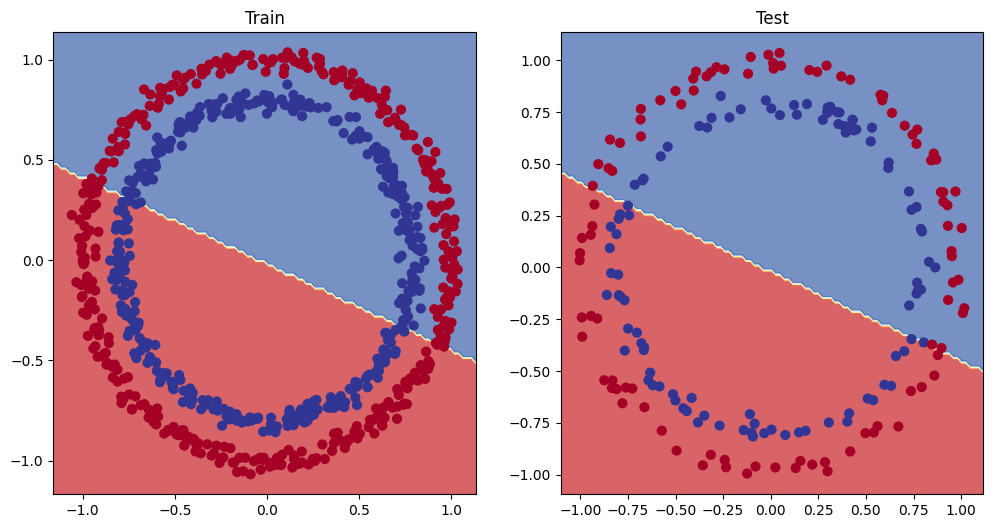

In [217]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_01,X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_01,X_test,Y_test)

# 5.Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units- from 5 hidden units to 10 hidden units
* Fit for longer 
* Changing the activation functions
* Changing learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model,rather than the data.
<br>

And because these options are all values we can change they are referred as **hyperparameters**

In [218]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2060], device='cuda:0'))])

In [219]:
## Adding hidden units

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10 , out_features=1)

    def forward(self,X):
        z = self.layer_1(X)
        z = self.layer_2(z)
        z = self.layer_3(z)

        # return z # we can use this return also if we need
    
        return z   
    

model_1 = CircleModelV1().to(device)
model_1    

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [220]:
model_1 = CircleModelV1().to(device)
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimize 
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [221]:
# write training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    model_1.train()

    y_logits1 = model_1(X_train).squeeze()
    y_pred1 = torch.round(torch.sigmoid(y_logits1))

    loss = loss_fn(y_logits1,Y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    acc = accuracy_fn(y_true=Y_train,
                      y_pred=y_pred1)


    ## Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits1 = model_1(X_test).squeeze()
        test_pred1 = torch.round(torch.sigmoid(test_logits1))

        test_loss1 = loss_fn(test_logits1,Y_test)

        test_acc1 = accuracy_fn(y_true=Y_test,
                                y_pred=test_pred1)
        

    if epoch % 100 ==0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc:.2f} | Test loss {test_loss1: .5f},Test acc: {test_acc1:.2f}%")     


        
    

Epoch: 0 | Loss:  0.70616, Acc: 50.00 | Test loss  0.70149,Test acc: 50.00%
Epoch: 100 | Loss:  0.69306, Acc: 51.88 | Test loss  0.69364,Test acc: 48.50%
Epoch: 200 | Loss:  0.69299, Acc: 50.75 | Test loss  0.69425,Test acc: 47.00%
Epoch: 300 | Loss:  0.69298, Acc: 51.25 | Test loss  0.69450,Test acc: 46.00%
Epoch: 400 | Loss:  0.69298, Acc: 51.50 | Test loss  0.69460,Test acc: 45.00%
Epoch: 500 | Loss:  0.69298, Acc: 51.50 | Test loss  0.69465,Test acc: 45.00%
Epoch: 600 | Loss:  0.69298, Acc: 51.25 | Test loss  0.69467,Test acc: 45.00%
Epoch: 700 | Loss:  0.69298, Acc: 51.12 | Test loss  0.69467,Test acc: 46.00%
Epoch: 800 | Loss:  0.69298, Acc: 51.12 | Test loss  0.69468,Test acc: 46.00%
Epoch: 900 | Loss:  0.69298, Acc: 51.00 | Test loss  0.69468,Test acc: 46.00%


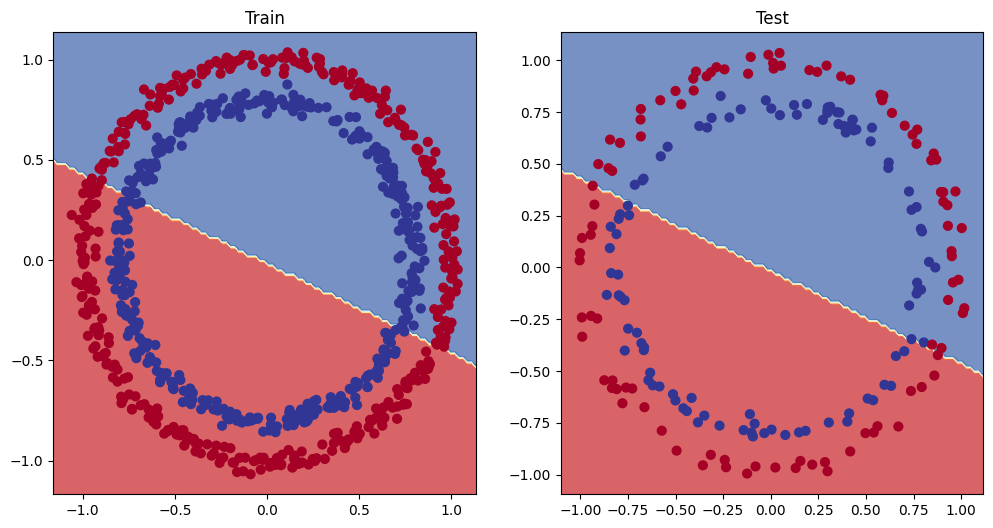

In [222]:
# Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test,Y_test)

# 5.1 Preparing data to see if our model can fit a straight line 

One way to troubleshoot to a large problem is to test out a smaller problem

In [223]:
# Create some data 

weight = 0.7
bias =0.3 
start = 0 
end = 1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
Y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5],Y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [224]:
# Create split
train_split = int(0.8*len(X_regression))

X_train_regression,Y_train_regression = X_regression[:train_split] , Y_regression[:train_split]
X_test_regression,Y_test_regression = X_regression[train_split:] , Y_regression[train_split:]

len(X_train_regression),len(Y_train_regression) , len(X_test_regression) , len(Y_test_regression)

(80, 80, 20, 20)

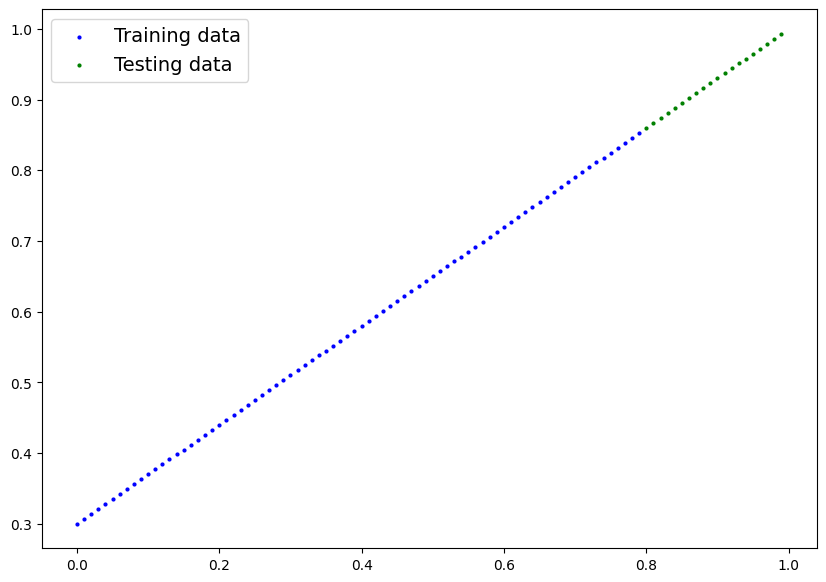

In [225]:
plot_predictions(train_data=X_train_regression,
                 train_labels=Y_train_regression,
                 test_data=X_test_regression,
                 test_labels=Y_test_regression)

# 5.2 Adjusting 'model_1' to fit a straight line


In [226]:
# Same architecture as model_1 (but using nn.sequential())

model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
    ).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [227]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr = 0.01)

In [228]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression,Y_train_regression = X_train_regression.to(device) , Y_train_regression.to(device)
X_test_regression,Y_test_regression = X_test_regression.to(device) , Y_test_regression.to(device)


for epoch in range(epochs):
    model_2.train()

    y_pred = model_2(X_train_regression)

    loss = loss_fn(y_pred,Y_train_regression)


    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    #Test
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred,Y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch:{epoch} | Loss:{loss:.5f} | Test loss: {test_loss:.5f}")     

    

Epoch:0 | Loss:0.75986 | Test loss: 0.91103
Epoch:100 | Loss:0.02858 | Test loss: 0.00081
Epoch:200 | Loss:0.02533 | Test loss: 0.00209
Epoch:300 | Loss:0.02137 | Test loss: 0.00305
Epoch:400 | Loss:0.01964 | Test loss: 0.00341
Epoch:500 | Loss:0.01940 | Test loss: 0.00387
Epoch:600 | Loss:0.01903 | Test loss: 0.00379
Epoch:700 | Loss:0.01878 | Test loss: 0.00381
Epoch:800 | Loss:0.01840 | Test loss: 0.00329
Epoch:900 | Loss:0.01798 | Test loss: 0.00360


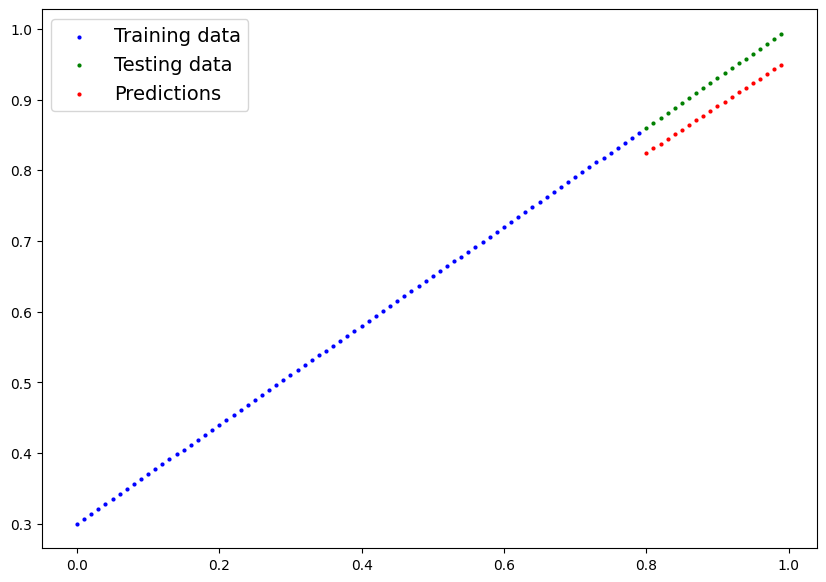

In [229]:
# Turn on evaluation
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)


plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=Y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=Y_test_regression.cpu(),
                 predictions=y_preds.cpu())    

# 6. The missing piece: is non-kinearity

""What pattern could you draw if you were given an infinite amount of a straight and non-straight lines?" 

or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles) 

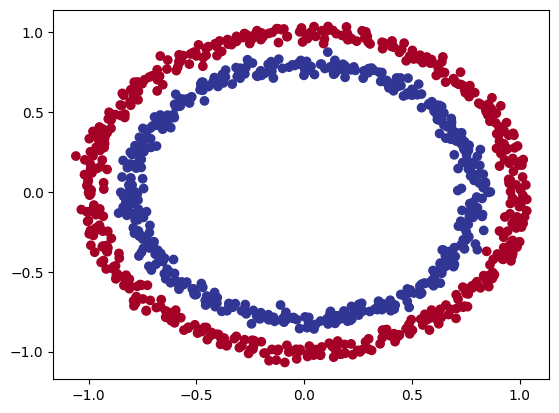

In [230]:
#Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,Y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:,0],X[:,1],c=Y,cmap=plt.cm.RdYlBu);

In [231]:
#Convert data to tensors and then split
import torch
from sklearn.model_selection import train_test_split

#Turn data into tensors

X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

# Splitting the data

X_train , X_test , Y_train, Y_test = train_test_split(X,
                                                      Y,
                                                      test_size=0.2,
                                                      random_state=42)

In [232]:
X_train[:5],Y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

# 6.2 Building a Model with non-linearity

* Linear = straight linear
* Non-linear = non-straight lines

Artificial neural network are large combination of linear(straight) and non-linear function which are potentially able to find patterns in data

In [233]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10)
        self.layer_2 = nn.Linear(in_features=10,out_features=10)
        self.layer_3 = nn.Linear(in_features=10 , out_features=1)
        self.relu = nn.ReLU() # relu is a non-linear activation function

    def forward(self,X):
        z = self.layer_1(X)
        z = self.layer_2(z)
        z = self.layer_3(z)

        # return z
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))      

In [234]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [235]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [236]:
# Training loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train,Y_train = X_train.to(device),Y_train.to(device)
X_test,Y_test = X_test.to(device),Y_test.to(device)

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    acc = accuracy_fn(y_true=Y_train,
                      y_pred=y_pred)
    
    loss = loss_fn(y_logits,Y_train)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    ## Testing
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()

        test_loss = loss_fn(test_logits,Y_test)

        test_pred = torch.round(torch.sigmoid(test_logits))

        test_acc = accuracy_fn(y_true=Y_test,
                        y_pred=test_pred)

    if epoch % 100 ==0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc:.2f} | Test loss {test_loss: .5f},Test acc: {test_acc:.2f}%")     
     

Epoch: 0 | Loss:  0.69295, Acc: 50.00 | Test loss  0.69319,Test acc: 50.00%
Epoch: 100 | Loss:  0.69115, Acc: 52.88 | Test loss  0.69102,Test acc: 52.50%
Epoch: 200 | Loss:  0.68977, Acc: 53.37 | Test loss  0.68940,Test acc: 55.00%
Epoch: 300 | Loss:  0.68795, Acc: 53.00 | Test loss  0.68723,Test acc: 56.00%
Epoch: 400 | Loss:  0.68517, Acc: 52.75 | Test loss  0.68411,Test acc: 56.50%
Epoch: 500 | Loss:  0.68102, Acc: 52.75 | Test loss  0.67941,Test acc: 56.50%
Epoch: 600 | Loss:  0.67515, Acc: 54.50 | Test loss  0.67285,Test acc: 56.00%
Epoch: 700 | Loss:  0.66659, Acc: 58.38 | Test loss  0.66322,Test acc: 59.00%
Epoch: 800 | Loss:  0.65160, Acc: 64.00 | Test loss  0.64757,Test acc: 67.50%
Epoch: 900 | Loss:  0.62362, Acc: 74.00 | Test loss  0.62145,Test acc: 79.00%


# 6.4 Evaluating a model training with non-linear activation functions

In [237]:
# Makes predictions
model_3.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10] , Y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

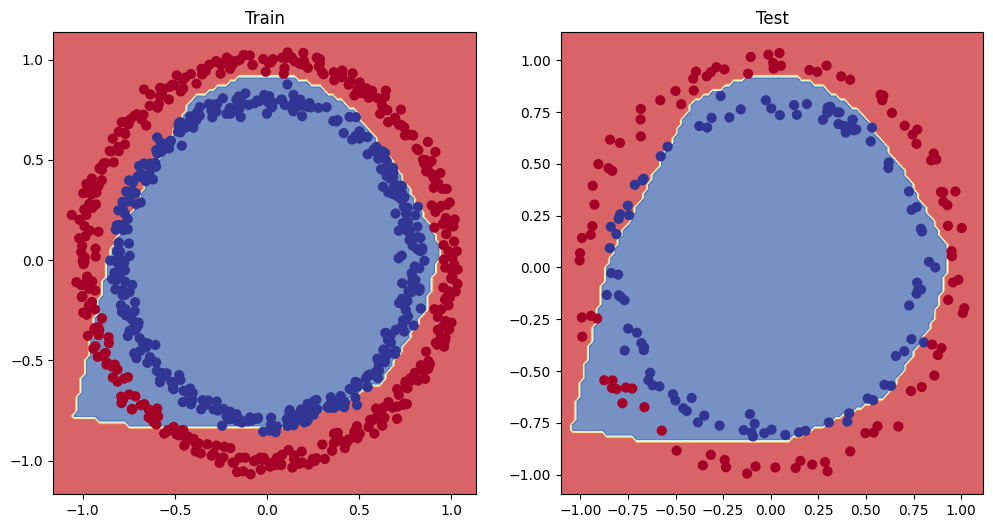

In [238]:
#plot decision boundaries

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3,X_train,Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3,X_test,Y_test)

# 7. Replicating non-linear activation function

Neural network rather than us telling the model what to learn, we give it tools to discover patterns in data and it tries to figure out the patterns on its own
<br>
And these tools are linear and non-linear function

In [239]:
# Create tensors
A = torch.arange(-10,10,1,dtype=torch.float32)
A.dtype

torch.float32

In [240]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

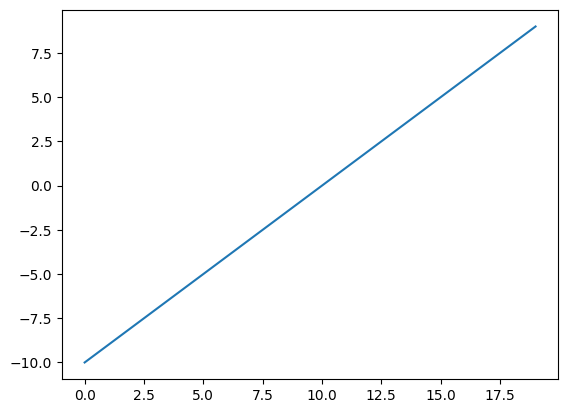

In [241]:
# Visualize the tensor
plt.plot(A);

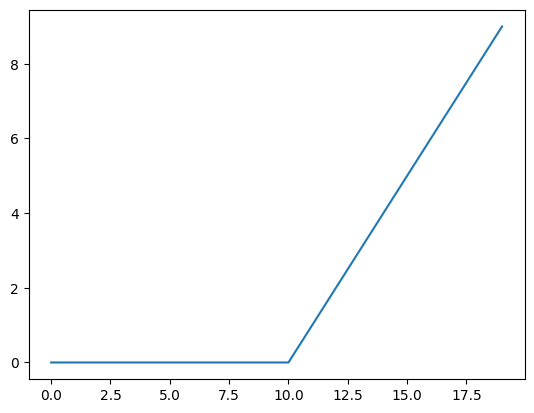

In [242]:
plt.plot(torch.relu(A));

In [243]:
def relu(x):
    return torch.maximum(torch.tensor(0),x)  # input should be tensors

In [244]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

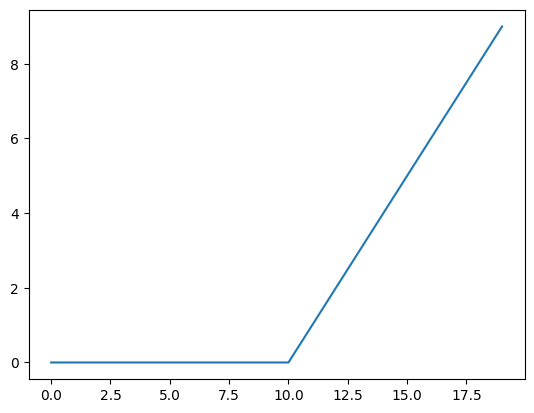

In [245]:
#Plot ReLU activation function
plt.plot(relu(A));

In [246]:
# Now let's do same for sigmoid

def sigmoid(x):
    return 1/(1+torch.exp(-x))

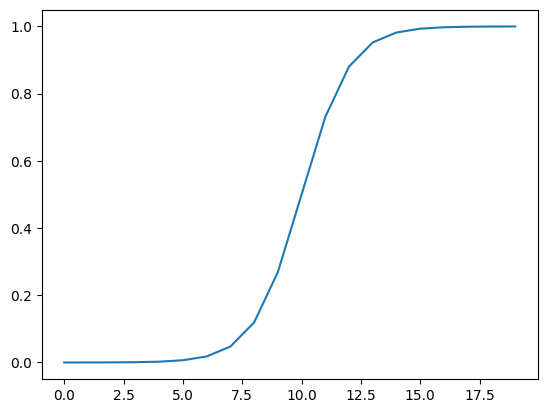

In [247]:
plt.plot(torch.sigmoid(A))

# 8. Putting all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs dog,spam vs not spam,fraud or not fraud) 

* Multi-class classification = more than one thing or another (cat vs dog vs chicken)

8.1 Creating toy multi-class Model 

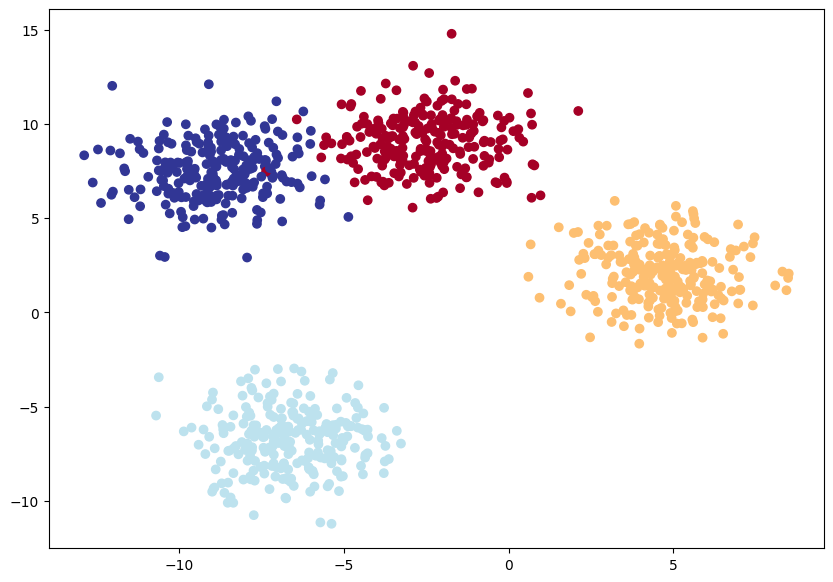

In [248]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data

X_blob,Y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)


# 2. Turn dat into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.LongTensor)

# 3. Split into train and test

X_blob_train , X_blob_test , Y_blob_train , Y_blob_test = train_test_split(X_blob,
                                                                           Y_blob,
                                                                           test_size=0.2,
                                                                           random_state=RANDOM_SEED)





#4. plot data

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=Y_blob , cmap=plt.cm.RdYlBu);

# 8.2 Building a multi-class classification model in pytorch

In [249]:
device = "cuda" if torch.cuda.is_available() else "CPU"

device

'cuda'

In [250]:
class BlobModel(nn.Module):
    def __init__(self,input_features,output_features , hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)
            )
        
    def forward(self,x):
        return self.linear_layer_stack(x)
    

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [251]:
X_blob_train.shape , Y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [252]:
torch.unique(Y_blob_train)

tensor([0, 1, 2, 3])

In [253]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

# 8.4 Getting prediction probabilities for a multi-class pytorch model

In order to evaluate and train and test our model, we need to convert our model's outputs(logits) to prediction probabilities and then to prediction labels.
<br>

Logits (raw output of the model) -> pred probs (use 'torch.softmax') -> pred labels (take the argmax of the prediction probabilites)


In [254]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

y_logits[:5]    

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')

In [255]:
# Convert our model's logit output to prediction probilities

y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [256]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [257]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

In [258]:
# Convert our model's prediction probilities to prediction labels

y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds


tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

# 8.5 Creating training and testing loop

In [259]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_blob_train,Y_blob_train = X_blob_train.to(device), Y_blob_train.to(device)
X_blob_test,Y_blob_test = X_blob_test.to(device), Y_blob_test.to(device)




epochs = 100

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

    loss = loss_fn(y_logits,Y_blob_train)

    acc = accuracy_fn(y_true=Y_blob_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ##Testing
    model_4.eval()
    with torch.inference_mode():
        y_test_logits=model_4(X_blob_test)
        y_test_pred = torch.softmax(y_test_logits,dim=1).argmax(dim=1)

        y_test_loss = loss_fn(y_test_logits,Y_blob_test)

        test_acc = accuracy_fn(y_true=Y_blob_test,
                               y_pred=y_test_pred)
        
    if epoch % 10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f}, Acc: {acc:.2f} | Test loss {test_loss: .5f},Test acc: {test_acc:.2f}%")     


Epoch: 0 | Loss:  1.15883, Acc: 40.38 | Test loss  0.57440,Test acc: 48.00%
Epoch: 10 | Loss:  0.64476, Acc: 96.75 | Test loss  0.57440,Test acc: 97.50%
Epoch: 20 | Loss:  0.42535, Acc: 98.50 | Test loss  0.57440,Test acc: 100.00%
Epoch: 30 | Loss:  0.25294, Acc: 99.12 | Test loss  0.57440,Test acc: 99.50%
Epoch: 40 | Loss:  0.11232, Acc: 99.25 | Test loss  0.57440,Test acc: 99.50%
Epoch: 50 | Loss:  0.06627, Acc: 99.25 | Test loss  0.57440,Test acc: 99.50%
Epoch: 60 | Loss:  0.05068, Acc: 99.25 | Test loss  0.57440,Test acc: 99.50%
Epoch: 70 | Loss:  0.04300, Acc: 99.25 | Test loss  0.57440,Test acc: 99.50%
Epoch: 80 | Loss:  0.03836, Acc: 99.25 | Test loss  0.57440,Test acc: 99.50%
Epoch: 90 | Loss:  0.03525, Acc: 99.25 | Test loss  0.57440,Test acc: 99.50%


# 8.6 Making and evaluating prediction with pytorch multi-class model 

In [260]:
#Make prediction
model_4.eval()
with torch.inference_mode():
    y_logits= model_4(X_blob_test)

y_logits[:10]    

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [262]:
# Go from logits -> Prediction Probabilities
y_pred_probs = torch.softmax(y_logits ,dim=1)
y_pred_probs[:5]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05]], device='cuda:0')

In [263]:
y_preds = torch.argmax(y_pred_probs,dim=1)

In [264]:
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

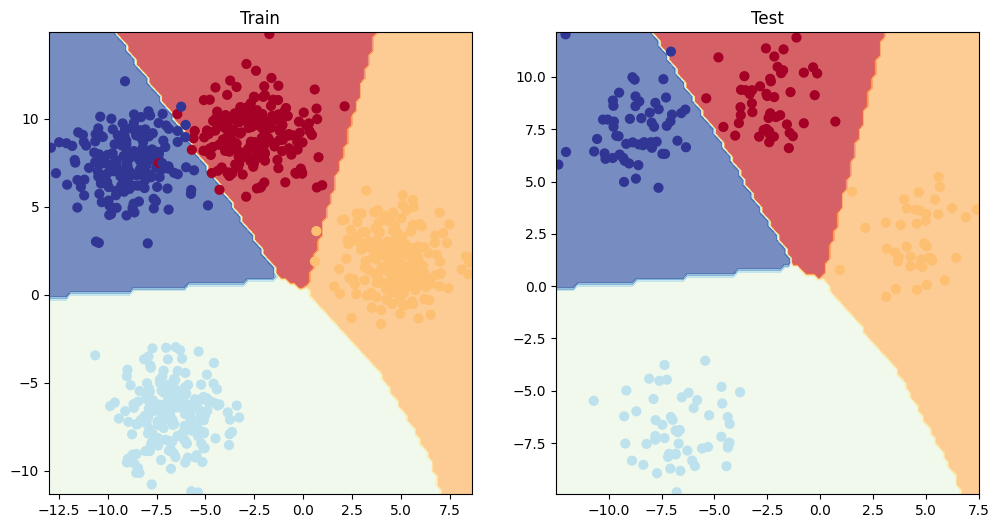

In [265]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train,Y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,Y_blob_test)


9. A few more classification metics (to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right ?
* Precision  
* Recall
* F1 - Score
* Confusion matrix
* classification report



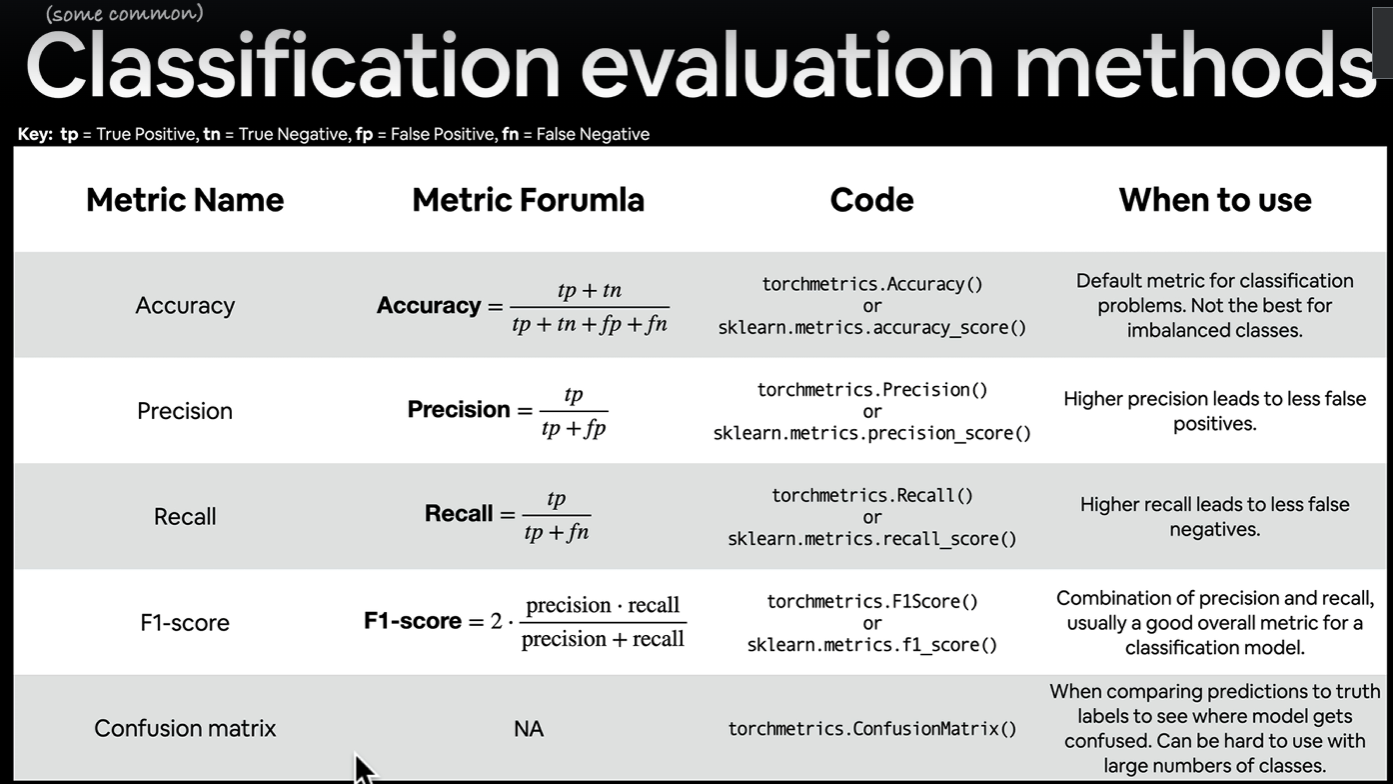